# PROJECT REPORT IE 582  

#### Ahmet Buğra TAKSUK
#### Ayşen AKBAL
#### Dorukhan KILINÇ
-----------------------------
>
>

## 1) Introduction and Problem Definition
#### In this project our main task is to build a classification model to predict the gender information with the given data provided by Trendyol.
#### This prediction project consists of three separate phases ;#

▶ Data Analysis & Data Preprocessing  
▶ Model Selection & Model Tuning    
▶ Evaluation & Prediction


#### In the targeted estimation project, we have two different datasets which are test and training data. Train data used for model building and test data used for model evaluation. Train set has the feature columns and the target column that expressing gender. Test data has same feature columns except unlabeled target column. The training and testing data were selected randomly from the original data set.





## 2) Data Analysis


#### 2.1) Imported Libraries

In [ ]:
import numpy as np
import pandas as pd
import missingno as msn
import seaborn as sns 
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 2.1) Dataset

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/trainData.csv')
test_data = pd.read_csv('/content/drive/MyDrive/testData.csv')

##### Train dataset consist of 19 columns which shows :

• time_stamp: Timestamp of the action  
• contentid: Id of the product  
• user_action: type of the action (i.e. visit, search, basket and etc.)  
• sellingprice: price of the item  
• product_name: name of the product  
• brand_id: brand id of the product  
• brand_name: brand of the product  
• businessunit: business unit information for the product  
• product_gender: gender of the product if defined  
• category_id: caegory id in which product is belonging to.  
• Level1_Category_Id: category id in the first hierarchy  
• Level1_Category_Name: category name in the first hierarchy  
• Level2_Category_Id: category id in the second hierarchy  
• Level2_Category_Name: category name in the second hierarchy  
• Level3_Category_Id: category id in the third hierarchy  
• Level3_Category_Name: category name in the third hierarchy  
• gender: this is the class information  
• unique_id: id of the user  
• type: type of the data (just for information purposes, train and test)  


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5493268 entries, 0 to 5493267
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   time_stamp            object 
 1   contentid             float64
 2   user_action           object 
 3   sellingprice          float64
 4   product_name          object 
 5   brand_id              float64
 6   brand_name            object 
 7   businessunit          object 
 8   product_gender        object 
 9   category_id           float64
 10  Level1_Category_Id    float64
 11  Level1_Category_Name  object 
 12  Level2_Category_Id    float64
 13  Level2_Category_Name  object 
 14  Level3_Category_Id    float64
 15  Level3_Category_Name  object 
 16  gender                object 
 17  unique_id             int64  
 18  type                  object 
dtypes: float64(7), int64(1), object(11)
memory usage: 796.3+ MB


In [ ]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
contentid,5493264.0,3.789317e+07,1.687660e+07,48852.0,32586011.00,42313392.00,49755813.00,67806253.0
sellingprice,5402828.0,2.308406e+02,1.114896e+03,0.0,49.99,89.99,179.99,226320.0
brand_id,5487630.0,1.759456e+05,3.532670e+05,9.0,1042.00,9053.00,35577.00,1042155.0
category_id,5487630.0,1.211124e+03,9.056135e+02,369.0,578.00,772.00,1829.00,4577.0
Level1_Category_Id,5487630.0,8.158548e+02,6.569286e+02,368.0,522.00,522.00,758.00,3186.0
Level2_Category_Id,5487630.0,1.633801e+03,1.074936e+03,387.0,503.00,1201.00,2869.00,4572.0
Level3_Category_Id,5487630.0,1.187261e+03,8.294032e+02,369.0,567.00,975.00,1190.00,4591.0
unique_id,5493268.0,1.127895e+03,1.332984e+03,1.0,178.00,611.00,1549.00,7997.0


#### 2.3) Missing Values

In [ ]:
train_data.isna().sum()

time_stamp                   0
contentid                    4
user_action                  0
sellingprice             90440
product_name              5638
brand_id                  5638
brand_name                5638
businessunit              5638
product_gender          621972
category_id               5638
Level1_Category_Id        5638
Level1_Category_Name      5638
Level2_Category_Id        5638
Level2_Category_Name      5638
Level3_Category_Id        5638
Level3_Category_Name      5638
gender                       0
unique_id                    0
type                         0
dtype: int64

#### 2.4) Feauture Correlation Analysis

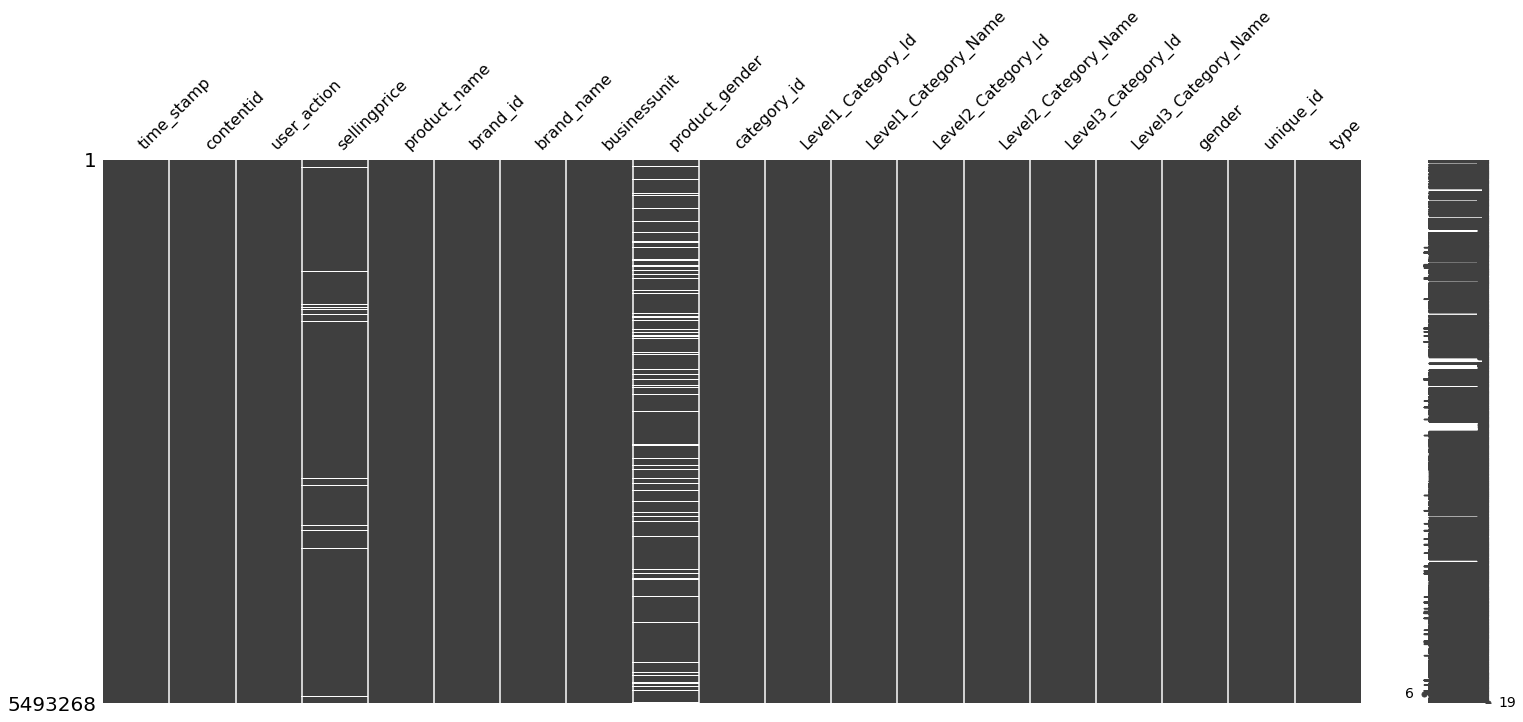

In [ ]:
msn.matrix(train_data)

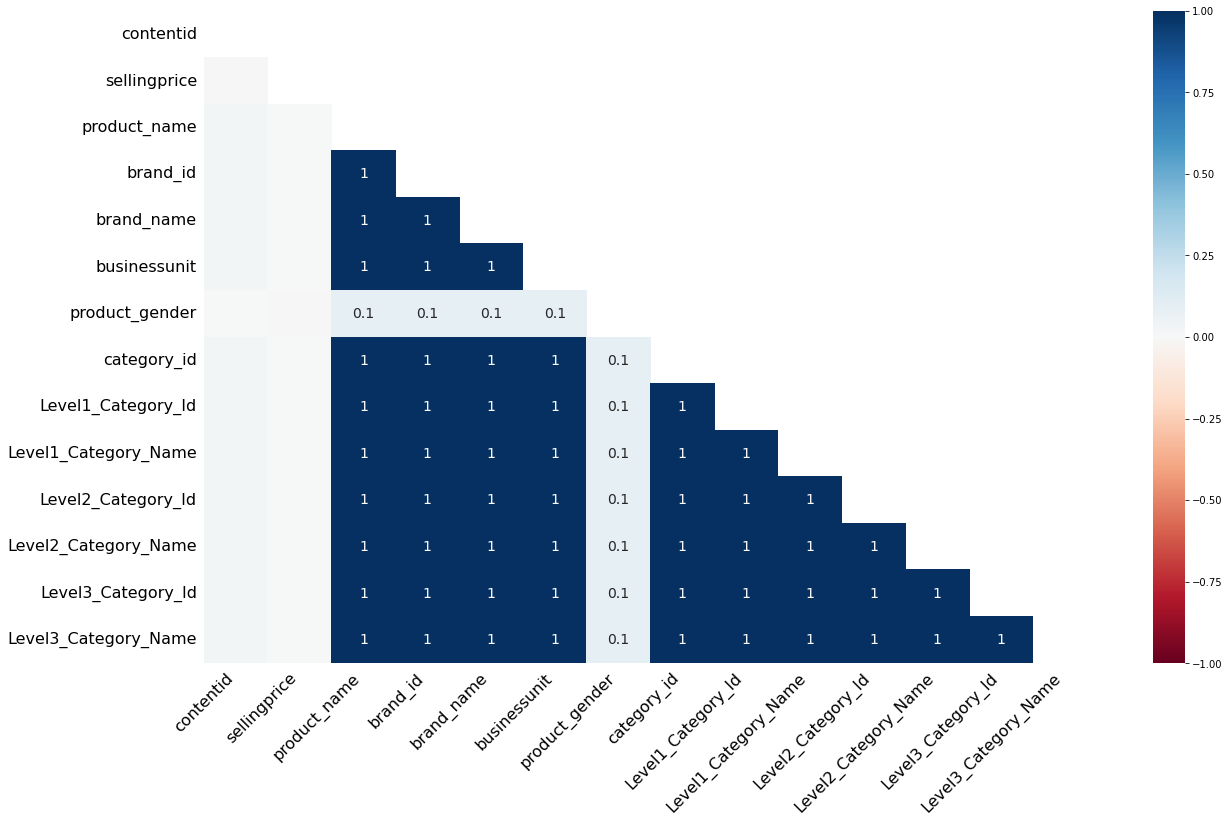

In [ ]:
msn.heatmap(train_data)

### 3) Data Preprocessing

Preparing proper dataset is the fundamental part before model building so for improving the performance of model we wanted to rearrange some columns structure. We use numerical binnig for **selling price** column. But first of all we have filled missing values with median of the related column. After this process, for finding the outlier points that are significantly different from the majority of the other data points in price column, we use **IsolationForest** that isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature.

The second notable column in terms of the nan values is the **product_gender**. In order not to affect the meaning of this column for us and not to lose such a large number of data, the nan values in the relevant column have been assigned as Unisex.

In the next step, some of them were dropped considering the correlation of the data in the data set with each other and their effect on the gender estimation we aim for.

After that we use encoding for some columns( **user_action', 'product_gender',   'businessunit','Level1_Category_Id', 'Level2_Category_Id'**)which are challenging to understand in terms of algorithms, enables us to group our data without losing any information.

It is important to note that, because of the computational problems, level 3 category id which has hundreds of catergoricals is removed. 

In addition, since we are asked to predict the gender of the users and the data is in the form of transactions as rows, after dummy varible creation, each column's mean is taken after grouping with respect to the unique user id. 

Another proposition was to make gender predictions for each transaction and then to take the mean of the gender probability predictions to find a prediction for each user. However, first proposition performed better and was computationally faster, since by grouping the data we reduce the rows for models to train on.

Finally, this aggregation with respect to the user id changed the class balances. Originally, there were around 1:9 ratio of male customer to the females. After, this ratio become 35:65 which around 1:2. An advantage of this was although we still used balanced accuracy as the metric for model training, we had a more-balanced set which is an advantage. 


#### 3.1) Column Selection and Dummy Variable Creation

For dummy variable creation, we merged the train and test set together to have consistent dataframes, because we need each dataframe to have the exact same columns in the same order. 

In [ ]:
data_whole = pd.concat([train_data, test_data], ignore_index = True)


data_whole.loc[ data_whole["sellingprice"] == 0, "sellingprice"] = data_whole["sellingprice"].median()
data_whole['sellingprice'].fillna(data_whole["sellingprice"].median(),inplace= True)

from sklearn.ensemble import IsolationForest

clf = IsolationForest( random_state = 1, contamination= 'auto')
preds = clf.fit_predict(data_whole["sellingprice"].values.reshape(-1,1))
mask = preds != -1

data_whole["Is_Low"] = 0
data_whole["Is_Above"] = 0
data_whole["Is_Med"] = 0
data_whole["Is_High"] = 0
data_whole["Is_Very_High"] = 0
data_whole["Is_Extreme"] = 0

data_whole['Is_Low'][data_whole['sellingprice'] < 12.63] = 1
data_whole['Is_Above'][(data_whole['sellingprice'] < 55) & (data_whole['sellingprice'] > 12.63)] = 1
data_whole['Is_Med'][(data_whole['sellingprice'] < 89.9 )& (data_whole['sellingprice'] > 55)] = 1
data_whole['Is_High'][(data_whole['sellingprice'] < 164 )& (data_whole['sellingprice'] > 89.9)] = 1
data_whole['Is_Very_High'][(data_whole['sellingprice'] < 333) & (data_whole['sellingprice'] > 164)] = 1
data_whole["Is_Extreme"][~mask] = 1


In [ ]:
data_whole['product_gender'].fillna("Unisex", inplace = True)
data_whole.dropna(subset = ["product_name"], inplace = True)
data_whole.reset_index(inplace = True )

In [ ]:
data_dummied = pd.get_dummies(data_whole, columns = ['user_action', 'product_gender','businessunit',
                                      'Level1_Category_Id', 'Level2_Category_Id'] )

data_dummied.drop(columns = ['time_stamp', 'contentid' , 'product_name', 'brand_name',
                           'Level1_Category_Name' , 'Level2_Category_Name','Level3_Category_Name',
                           "index", "sellingprice", "brand_id",
                                  "category_id", "Level3_Category_Id"], inplace = True)

#### 3.2) Aggregation with respect to User_id and train test split

As a new feature, we added the number of transactions made by each user as a new column.

In [ ]:
#accumulate binary matrix based on unique_id and normalize
acc = data_dummied.groupby("unique_id").sum()
counts = data_whole.groupby("unique_id").count()["index"]
normalized = acc.div(counts, axis = 0)

normalized["count"] = counts

train = data_whole[data_whole["type"] == "train"]["unique_id"].unique()
test = data_whole[data_whole["type"] == "test"]["unique_id"].unique()

data_train = normalized.loc[train]
data_test = normalized.loc[test]

data_whole["y"] = (data_whole["gender"] == "F")*1
y_train = data_whole.groupby("unique_id").sum().loc[train, "y"]
y_train = y_train.apply(lambda x: 1 if x > 0  else 0)

###4) Model Selection & Evaluation

For model selection and parameter tuning, GridSearchCV function is used and a custom scoring taking the average of the roc_auc score and balanced accuracy rate is used the scorer. Purposed models were decision trees, random forests, penalized logistic regression and gradient boosted trees. 



 

 #### 4.1) Scorer

In [ ]:
def prob_score(y, probs):
    return (balanced_accuracy_score(y , (probs > 0.5)*1) + roc_auc_score(y, probs))/2

custom_score = make_scorer(prob_score,needs_proba=True, greater_is_better=True)

#### 4.2) Perform CV and select the best model with the best parameters

In [ ]:
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))


model = xgb.XGBClassifier(use_label_encoder=False, random_state=0,
                         objective="binary:logistic", eval_metric='auc')

parameters = {'max_depth': [2, 3], 
              'eta': [0.1, 0.05],
              "scale_pos_weight": [0.6, 0.55, 0.5],
              "n_estimators" :[100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)

searcher = GridSearchCV(estimator=model,
                        scoring = score, cv=cv, param_grid= parameters)
grid_result = searcher.fit(data_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

allDone()

In [ ]:
model = LogisticRegression(max_iter = 1000, solver = "liblinear", class_weight= "balanced",
                          penalty = "l1", random_state = 0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)

parameters = {'C': [1, 2, 4, 5, 10]}

searcher = GridSearchCV(estimator=model,
                        scoring = score, cv=cv, param_grid= parameters)
grid_result = searcher.fit(data_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

allDone()

In [ ]:
model = RandomForestClassifier(random_state = 0, class_weight="balanced")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)

parameters = {'max_depth': [3, 4],
             'n_estimators': [50, 100, 150, 500]}

searcher = GridSearchCV(estimator=model,
                        scoring = score, cv=cv, param_grid= parameters)

grid_result = searcher.fit(data_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

allDone()

In [ ]:
model = DecisionTreeClassifier(random_state = 0, class_weight="balanced")

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=0)

parameters = {'max_depth': [10, 11, 12]}

searcher = GridSearchCV(estimator=model,
                        scoring = score, cv=cv, param_grid= parameters)

grid_result = searcher.fit(data_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

allDone()

### 5) Submission with the best Model

Looking at the cv scores, we concluded that the best model is XGBClassifier with parameters: ***eta = 0.01,
                        max_depth = 3, n_estimators= 1000, scale_pos_weight = 0.5,
                         objective="binary:logistic", eval_metric='auc'.***

After the selection of the best model, the model is trained using the whole train set and predictions are made using the test set. However, there was one user whose all transactions were na. Since we were required to make a submission for this user as well, we decided to predict the probability of this user being female as the ratio of the female users in the train data. 

In [ ]:
model_best = xgb.XGBClassifier(use_label_encoder=False, random_state=0, eta = 0.01,
                               max_depth = 3, n_estimators= 1000, scale_pos_weight = 0.5,
                         objective="binary:logistic", eval_metric='auc')

model_best.fit(data_train, y_train)

#write probs
sub = data_test.copy()
sub["probs"] = model_best.predict_proba(data_test)[:,1]

test_prob = sub.reset_index()[["unique_id", "probs"]]

ids = pd.read_csv("test_ids_in_prediction.csv")

y_prob = pd.merge(ids, test_prob, on = "unique_id", how = "left")
y_prob.loc[1372, "probs"] = np.mean(y_train)

np.savetxt("preds.txt", np.array(y_prob["probs"]), 
          delimiter ="",newline = ",", fmt ="%10.5f")

### 6) Conclusion

All in all, for gender prediction in an unbalanced setting, we used a custom metric combining the balanced accuracy score and roc_auc score. The data we used mostly consisted categorical columns, which required us to create dummy variables as new columns. However, there were so many categories, leading us to the exclusion of some of the varibles because of the computational problems we faced. We proposed different models, made parameter tuning using the custom metric we created and finally chose the model with the best scores to make the predictions. 

Our main limit in this project was the computation time needed to evaluate complex models because of the high number of categorical features in the set. We didn't want to make subsampling in this setting, since we didn't want to lose any information in the minority class. More complex models with a training set with more information would be run in the absence of a time limit.  

REFERENCES  
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html  
https://blog.paperspace.com/anomaly-detection-isolation-forest/  
https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

